<div align='center'>

# Probability and Statistics

### Part of Scientific-ML-Notes 

[![GitHub](https://img.shields.io/badge/GitHub-Repository-black?logo=github&scale=5)](https://github.com/mhnaderi/Scientific-ML-Notes)

---

In [1]:
# Always run this cell first to import all necessary libraries and set up the notebook environment

!pip install tinygp

import numpy as np
import scipy as sp
import numpy.linalg as la
from scipy.integrate import solve_ivp
from scipy.stats import multivariate_normal, gaussian_kde

import jax
import optax
import jax.numpy as jnp
from jax import random, jit, value_and_grad, vmap, grad, jacfwd
jax.config.update("jax_enable_x64", True)

from tinygp import kernels
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams.update({
    "font.family": "serif",
    "figure.facecolor": 'white',
    "axes.facecolor": 'white'
})

# Probability and Statistics

Probability can be interpreted in two main ways:

- **Frequentist Interpretation**:
  - Probability is defined as the long-run frequency of an event occurring over many trials.
  - *Example*: If we flip a coin many times, we expect it to land heads approximately half the time.

- **Bayesian Interpretation**:
  - Probability quantifies our degree of belief or uncertainty about an event, based on current information.
  - *Example*: Before flipping a coin, we assign equal probability to it landing heads or tails on the next toss.
  - *Advantage*: Suitable for modeling uncertainty in single events that aren't repeatable.

Uncertainty can be categorized into two types:

- **Epistemic Uncertainty (Systematic Uncertainty)**:
  - Arises due to limited data or knowledge; it can be reduced by collecting more data.

- **Aleatoric Uncertainty (Intrinsic Uncertainty or Noise)**:
  - Results from inherent randomness in the system; even with infinite data, it cannot be completely eliminated. Gathering different types of data may help reduce it.

**Probability Density Function (PDF):**

A probability density function $p(x)$ represents the likelihood of a continuous random variable taking on the value $x$. It must satisfy the following properties:

1)
$$
p(x) \geq 0 \quad \text{for all } x
$$

2)
$$
\int_{-\infty}^{\infty} p(x) \, dx = 1
$$

**Cumulative Distribution Function (CDF):**

The cumulative distribution function $F(x)$ represents the cumulative probability up to a point $x$, and is defined as:

$$
F(x) = \int_{-\infty}^{x} p(t) \, dt
$$

The relationship between the PDF and the CDF is:

- PDF is the derivative of the CDF:
$$
p(x) = \dfrac{d}{dx} F(x)
$$

- CDF is the integral of the PDF:
$$
F(x) = \int_{-\infty}^{x} p(t) \, dt
$$

## Rules of Probability

1. **Sum Rule**

   The marginal probability of $x$ is obtained by integrating the joint probability over all values of $y$:

   $$
   p(x) = \int p(x, y) \, dy
   $$

2. **Product Rule**

   The joint probability of $x$ and $y$ can be expressed using conditional probabilities:

   $$
   p(x, y) = p(x \mid y) \, p(y) = p(y \mid x) \, p(x)
   $$

   If $x$ and $y$ are independent, then:

   $$
   p(x, y) = p(x) \, p(y)
   $$

- **Joint Probability** $p(x, y)$: The probability of both $x$ and $y$ occurring together.
- **Conditional Probability** $p(y \mid x)$: The probability of $y$ given that $x$ has occurred.
- **Marginal Probability** $p(x)$: The probability of $x$, irrespective of other variables.

### Conditioning

Conditioning involves finding the probability distribution of a variable given that another variable is known. The conditional probability of $x$ given $y$ is defined as:

$$
p(x \mid y) = \frac{p(x, y)}{p(y)}
$$

### Marginalization

Marginalization is the process of deriving the probability distribution of a subset of variables by integrating over the other variables. The marginal distribution of $x$ is:

$$
p(x) = \int p(x \mid y) \, p(y) \, dy
$$

This integrates the conditional probability over all possible values of $y$.

## Bayes' Rule

Bayes' theorem relates the conditional and marginal probabilities of random events:

$$
p(y \mid x) = \frac{p(x \mid y) \, p(y)}{p(x)} = \frac{p(x \mid y) \, p(y)}{\int p(x \mid y) \, p(y) \, dy} = \frac{p(x, y)}{\int p(x, y) \, dy}
$$

Where:

- $p(x \mid y)$ is the **likelihood**.
- $p(y)$ is the **prior probability**.
- $p(x)$ is the **evidence**.

**Example:**

Suppose we want to find the probability that a person is a librarian ($y$) given that they are shy ($x$). Given:

- **Prior Probability** $p(y)$: 10% chance of being a librarian, so $p(y) = 0.1$.
- **Likelihood** $p(x \mid y)$: 80% of librarians are shy, so $p(x \mid y) = 0.8$.
- **Likelihood for Non-Librarians** $p(x \mid \neg y)$: 30% of non-librarians are shy, so $p(x \mid \neg y) = 0.3$.

Compute the evidence $p(x)$:

$$
\begin{align*}
p(x) &= p(x \mid y) \, p(y) + p(x \mid \neg y) \, p(\neg y) \\
&= (0.8 \times 0.1) + (0.3 \times 0.9) \\
&= 0.08 + 0.27 = 0.35
\end{align*}
$$

Apply Bayes' theorem to find $p(y \mid x)$:

$$
p(y \mid x) = \frac{p(x \mid y) \, p(y)}{p(x)} = \frac{0.8 \times 0.1}{0.35} \approx 0.229
$$

So, there's approximately a 22.9% chance the person is a librarian given they are shy.

**Note:** Variables $x$ and $y$ can represent multiple events, forming a vector $\mathbf{x} = (x_1, x_2, \ldots, x_D)$, and the joint probability becomes $p(\mathbf{x}) = p(x_1, x_2, \ldots, x_D)$.

### Bayes' Rule for Inverse Problems

In many cases, we aim to infer hidden causes $h$ from observed data $y$, effectively reversing the usual prediction process. For example, deducing a 3D structure $h$ from a 2D image $y$ in computer vision is an inverse problem. Since multiple hidden states can produce the same observation, these problems are often ill-posed.

By applying Bayes' theorem, we can compute the posterior distribution $p(h \mid y)$:

$$
p(h \mid y) = \frac{p(y \mid h) \, p(h)}{p(y)}
$$

- **Likelihood** $p(y \mid h)$: The probability of observing $y$ given the hidden state $h$.
- **Prior** $p(h)$: Our initial belief about the possible states $h$.
- **Posterior** $p(h \mid y)$: Updated belief about $h$ after observing $y$.

Using Bayes' rule allows us to incorporate prior knowledge and quantify uncertainty when inferring hidden causes from data.

## Expectation

The **expectation** (or **expected value**) of a random variable represents the average value it takes. For a function $f(x)$ of a random variable $x$, the expectation is defined as:

- For continuous variables:
  $$
  E_p[f(x)] = \int f(x) \, p(x) \, dx
  $$

- For discrete variables:
  $$
  E_p[f(x)] = \sum_x f(x) \, p(x)
  $$

Here, $p(x)$ is the probability density function (PDF) for continuous variables or the probability mass function (PMF) for discrete variables. The expectation can also be viewed as the inner product of $f(x)$ and $p(x)$:
$$
E_p[f(x)] = \langle f(x), \, p(x) \rangle
$$

Common expectations include:

- **Mean ($\mu$)**:
  $$
  \mu = E_p[x] = \int x \, p(x) \, dx
  $$

- **Variance ($\sigma^2$)**:
  $$
  \sigma^2 = \operatorname{Var}[x] = E_p\left[ (x - E_p[x])^2 \right] = E_p[x^2] - \left( E_p[x] \right)^2 = \int (x - \mu)^2 \, p(x) \, dx
  $$

- **$p$-Norm**:
  $$
  \| x \|_p = \left( E_p\left[ |x|^p \right] \right)^{1/p} = \left( \int |x|^p \, p(x) \, dx \right)^{1/p}
  $$

- **Entropy ($H(x)$)**:
  $$
  H(x) = E_p[-\log p(x)] = -\int p(x) \log p(x) \, dx
  $$

For two random variables $X$ and $Y$:

- **Covariance**:
  $$
  \operatorname{Cov}[X, Y] = E\left[ (X - E[X])(Y - E[Y]) \right]
  $$

- **Correlation (Pearson Correlation Coefficient)**:
  $$
  \operatorname{Corr}[X, Y] = \frac{ \operatorname{Cov}[X, Y] }{ \sqrt{ \operatorname{Var}[X] \operatorname{Var}[Y] } }
  $$

Covariance measures how much two variables change together. It can be any value between negative and positive infinity. The correlation coefficient is a normalized measure of the covariance and always ranges between -1 and 1, indicating the strength and direction of a linear relationship between variables.

If $X$ and $Y$ are independent, meaning $p(X, Y) = p(X) p(Y)$, then $\operatorname{Cov}[X, Y] = 0$, and thus $\operatorname{Corr}[X, Y] = 0$. Therefore, independence implies zero correlation (uncorrelated), but the converse is not necessarily true—uncorrelated variables are not always independent.

It's important to note that **correlation does not imply causation**.

The **mode** of a distribution is the value where the probability density (or mass) is highest:
$$
x^* = \underset{x}{\operatorname{arg\,max}} \, p(x)
$$

### Limitations of Summary Statistics

While mean and variance are useful for summarizing a distribution, they don't capture all characteristics of the data. Different datasets can have the same mean and variance yet differ significantly in their distributions. This highlights the importance of analyzing the data beyond just low-order summary statistics to fully understand its underlying structure.

## The Normal Distribution

The normal distribution, also known as the Gaussian distribution, is a continuous probability distribution defined by two parameters: the mean $\mu$ and the standard deviation $\sigma$, with variance $\sigma^2$. The probability density function (PDF) of the normal distribution is:

$$
p(x) = \frac{1}{\sqrt{2\pi \sigma^2}} \, \exp\left( -\frac{(x - \mu)^2}{2\sigma^2} \right)
$$

### Multivariate Normal Distribution

The multivariate normal distribution extends the normal distribution to multiple dimensions. It is characterized by the mean vector $\boldsymbol{\mu}$ and the covariance matrix $\boldsymbol{\Sigma}$. The PDF of the multivariate normal distribution is:

$$
\mathcal{N}(\mathbf{x}; \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{\sqrt{(2\pi)^D|\boldsymbol{\Sigma}|}} \, \exp\left( -\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^\top \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu}) \right)
$$

where $\boldsymbol{\mu} = \mathbb{E}[\mathbf{x}] \in \mathbb{R}^D$ is the mean vector, and $\boldsymbol{\Sigma} = \operatorname{Cov}[\mathbf{x}] \in \mathbb{R}^{D \times D}$ is the covariance matrix, which is symmetric and positive definite.

Maximum Error: 1.11e-16


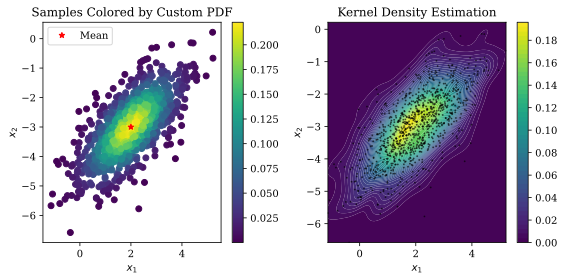

In [2]:
# Set the number of samples
num_samples = 1000

# Define the mean vector and covariance matrix
mean       = np.array([2.0, -3.0])
covariance = np.array([[1.0, 0.7],
                       [0.7, 1.0]])

# Generate samples from the multivariate normal distribution
samples = np.random.multivariate_normal(mean, covariance, num_samples)

# Custom function to compute the multivariate normal PDF
def multivariate_pdf(x, mean, cov):
    dim = x.shape[1]
    cov_inv = la.inv(cov)
    diff = x - mean
    exponent = -0.5 * np.einsum('ij,jk,ik->i', diff, cov_inv, diff)
    denominator = np.sqrt((2 * np.pi) ** dim * la.det(cov))
    pdf_values = np.exp(exponent) / denominator
    return pdf_values

# Compute density using the custom PDF function
custom_density = multivariate_pdf(samples, mean, covariance)

# Compute density using SciPy's PDF function
scipy_density = multivariate_normal.pdf(samples, mean=mean, cov=covariance)

# Compare the maximum error between the two methods
max_error = np.max(np.abs(custom_density - scipy_density))
print(f'Maximum Error: {max_error:.2e}')

# Create plots
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

# Scatter plot of samples colored by custom density
scatter = ax[0].scatter(samples[:, 0], samples[:, 1], c=custom_density, cmap='viridis')
ax[0].plot(mean[0], mean[1], 'r*', label='Mean')
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
ax[0].set_title('Samples Colored by Custom PDF')
ax[0].legend()
fig.colorbar(scatter, ax=ax[0])

# Kernel Density Estimation
kde = gaussian_kde(samples.T)
x_grid, y_grid = np.meshgrid(
    np.linspace(samples[:, 0].min(), samples[:, 0].max(), 100),
    np.linspace(samples[:, 1].min(), samples[:, 1].max(), 100)
)
grid_coords = np.vstack([x_grid.ravel(), y_grid.ravel()])
kde_values = kde(grid_coords).reshape(x_grid.shape)

# Plot KDE as a contour plot
contour = ax[1].contourf(x_grid, y_grid, kde_values, levels=50, cmap='viridis')
ax[1].plot(samples[:, 0], samples[:, 1], 'k.', markersize=2, alpha=0.5)
ax[1].set_xlabel('$x_1$')
ax[1].set_ylabel('$x_2$')
ax[1].set_title('Kernel Density Estimation')
fig.colorbar(contour, ax=ax[1])

plt.show()


Normal distribution are preserved under all linear operations:
- If a variable $\mathbf{x}$ is normal distributed, then every affine transformation of it also has a normal distribution. Consider an affine transformation of the random variable $\boldsymbol{y}=\boldsymbol{A}\mathbf{x}+\boldsymbol{b}$, then random variable $\boldsymbol{y}$ follows a normal distribution:
$$
y = \mathcal{N}\left(\boldsymbol{y}; \boldsymbol{A} \boldsymbol{\mu}+\boldsymbol{b}, \boldsymbol{A} \boldsymbol{\Sigma} \boldsymbol{A}^{\top}\right)
$$
although note we might have $\left|\boldsymbol{A} \boldsymbol{\Sigma} \boldsymbol{A}^{\top}\right|=0$.

- The product of two Gaussian probability density functions is another Gaussian probability distribution, scaled by a constant. The value of that constant is itself given by the value of a Gaussian density function. Let $p_1(\mathbf{x})$ and $p_2(\mathbf{x})$ be Gaussian PDFs defined on variables $\mathbf{x}$ and $\left(\boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1\right)$ be parameters of $p_1$ and $\left(\boldsymbol{\mu}_2, \boldsymbol{\Sigma}_2\right)$ for $p_2$. The product of the PDFs $p_1(\mathbf{x}) p_2(\mathbf{x})$ is proportional to a Gaussian density:
$$
\begin{aligned}
\boldsymbol{\Sigma} &= \left(\boldsymbol{\Sigma}_1^{-1}+\boldsymbol{\Sigma}_2^{-1}\right)^{-1} \\
\mu &= \boldsymbol{\Sigma} \boldsymbol{\Sigma}_1^{-1} \boldsymbol{\mu}_1+\boldsymbol{\Sigma} \boldsymbol{\Sigma}_2^{-1} \boldsymbol{\mu}_2
\end{aligned}
$$
although this density may not be normalized (may not integrate to 1 over all $\mathbf{x}$ ). But if we can write a probability as $p(\mathbf{x}) \propto p_1(\mathbf{x}) p_2(\mathbf{x})$ for 2 Gaussians, then $p$ is a Gaussian with the above mean/covariance.

The Gaussian distribution is the most widely used distribution in statistics and machine learning due to several reasons:
- **Interpretable Parameters**: It has two parameters: mean and variance, which are easy to interpret. These parameters capture basic properties of a distribution.
- **Central Limit Theorem**: Central limit theorem states that the distribution of the sum (or average) of a large number of independent, identically distributed random variables approaches a Gaussian distribution, regardless of the shape of the original distribution. This makes it suitable for modeling residual errors or “noise”.
- **Maximum Entropy**: The Gaussian distribution has maximum entropy given a specified mean and variance. It makes the least number of assumptions, making it a good default choice.
- **Simple Mathematical Form**: Its mathematical simplicity leads to easy implementation which often results in highly effective methods.

Limitations of the Gaussian distribution:
- **Parameter Growth**: The number of free parameters grows quadratically with the dimensionality $D$ of the data. This makes computations challenging for large $D$.
- **Mitigation Strategies**: Using restricted forms of the covariance matrix, such as diagonal or isotropic covariances. These reduce the number of parameters but limit the ability to capture complex correlations.
- **Unimodality**: The Gaussian distribution is inherently unimodal. It struggles to approximate multimodal distributions effectively.

### Marginals and Conditionals of an Multivariate Gaussian

Consider a joint Gaussian of the form $p\left(\boldsymbol{y}_1, \boldsymbol{y}_2\right)=\mathcal{N}(\boldsymbol{y} \mid \boldsymbol{\mu}, \boldsymbol{\Sigma})$, where:
$$
\boldsymbol{\mu}=\binom{\boldsymbol{\mu}_1}{\boldsymbol{\mu}_2}, \quad \boldsymbol{\Sigma}=\left(\begin{array}{ll}
\boldsymbol{\Sigma}_{11} & \boldsymbol{\Sigma}_{12} \\
\boldsymbol{\Sigma}_{21} & \boldsymbol{\Sigma}_{22}
\end{array}\right),
$$

and $\boldsymbol{\Sigma}^{-1}$ is the precision matrix. Then the marginals are given by:

$$
\begin{aligned}
& p\left(\boldsymbol{y}_1\right)=\mathcal{N}\left(\boldsymbol{y}_1 \mid \boldsymbol{\mu}_1, \boldsymbol{\Sigma}_{11}\right) \\
& p\left(\boldsymbol{y}_2\right)=\mathcal{N}\left(\boldsymbol{y}_2 \mid \boldsymbol{\mu}_2, \boldsymbol{\Sigma}_{22}\right)
\end{aligned}
$$

and the posterior conditional is given by:
$$
\begin{aligned}
p\left(\boldsymbol{y}_1 \mid \boldsymbol{y}_2\right) & =\mathcal{N}\left(\boldsymbol{y}_1 \mid \boldsymbol{\mu}_{1 \mid 2}, \boldsymbol{\Sigma}_{1 \mid 2}\right) \\
\boldsymbol{\mu}_{1 \mid 2} & =\boldsymbol{\mu}_1+\boldsymbol{\Sigma}_{12} \boldsymbol{\Sigma}_{22}^{-1}\left(\boldsymbol{y}_2-\boldsymbol{\mu}_2\right) \\
\boldsymbol{\Sigma}_{1 \mid 2} & =\boldsymbol{\Sigma}_{11}-\boldsymbol{\Sigma}_{12} \boldsymbol{\Sigma}_{22}^{-1} \boldsymbol{\Sigma}_{21}
\end{aligned}
$$


**Proof:**

Let us factor the joint $p\left(\boldsymbol{y}_1, \boldsymbol{y}_2\right)$ as $p\left(\boldsymbol{y}_2\right) p\left(\boldsymbol{y}_1 \mid \boldsymbol{y}_2\right)$ as follows:
$$
p\left(\boldsymbol{y}_1, \boldsymbol{y}_2\right) \propto \exp \left\{-\frac{1}{2}\binom{\boldsymbol{y}_1-\boldsymbol{\mu}_1}{\boldsymbol{y}_2-\boldsymbol{\mu}_2}^{\top}\left(\begin{array}{ll}
\boldsymbol{\Sigma}_{11} & \boldsymbol{\Sigma}_{12} \\
\boldsymbol{\Sigma}_{21} & \boldsymbol{\Sigma}_{22}
\end{array}\right)^{-1}\binom{\boldsymbol{y}_1-\boldsymbol{\mu}_1}{\boldsymbol{y}_2-\boldsymbol{\mu}_2}\right\}
$$

From Schur complements we have:

$$
\mathbf{M}^{-1} = 
\left(\begin{array}{cc}
\mathbf{E} & \mathbf{F} \\
\mathbf{G} & \mathbf{H}
\end{array}\right)^{-1}=\left(\begin{array}{cc}
\mathbf{I} & \mathbf{0} \\
-\mathbf{H}^{-1} \mathbf{G} & \mathbf{I}
\end{array}\right)\left(\begin{array}{cc}
(\mathbf{M} / \mathbf{H})^{-1} & \mathbf{0} \\
\mathbf{0} & \mathbf{H}^{-1}
\end{array}\right)\left(\begin{array}{cc}
\mathbf{I} & -\mathbf{F} \mathbf{H}^{-1} \\
\mathbf{0} & \mathbf{I}
\end{array}\right)
$$

Then the above exponent can be written with the Schur complements as follows:
$$
\begin{aligned}
p\left(\boldsymbol{y}_1, \boldsymbol{y}_2\right) & \propto \exp \left\{-\frac{1}{2}\binom{\boldsymbol{y}_1-\boldsymbol{\mu}_1}{\boldsymbol{y}_2-\boldsymbol{\mu}_2}^{\top}\left(\begin{array}{cc}
\mathbf{I} & \mathbf{0} \\
-\boldsymbol{\Sigma}_{22}^{-1} \boldsymbol{\Sigma}_{21} & \mathbf{I}
\end{array}\right)\left(\begin{array}{cc}
\left(\boldsymbol{\Sigma} / \boldsymbol{\Sigma}_{22}\right)^{-1} & \mathbf{0} \\
\mathbf{0} & \boldsymbol{\Sigma}_{22}^{-1}
\end{array}\right)\right. \left.\times\left(\begin{array}{cc}
\mathbf{I} & -\boldsymbol{\Sigma}_{12} \boldsymbol{\Sigma}_{22}^{-1} \\
\mathbf{0} & \mathbf{I}
\end{array}\right)\binom{\boldsymbol{y}_1-\boldsymbol{\mu}_1}{\boldsymbol{y}_2-\boldsymbol{\mu}_2}\right\} \\
& =\exp \left\{-\frac{1}{2}\left(\boldsymbol{y}_1-\boldsymbol{\mu}_1-\boldsymbol{\Sigma}_{12} \boldsymbol{\Sigma}_{22}^{-1}\left(\boldsymbol{y}_2-\boldsymbol{\mu}_2\right)\right)^{\top}\left(\boldsymbol{\Sigma} / \boldsymbol{\Sigma}_{22}\right)^{-1}\right. \\
& \left.\left(\boldsymbol{y}_1-\boldsymbol{\mu}_1-\boldsymbol{\Sigma}_{12} \boldsymbol{\Sigma}_{22}^{-1}\left(\boldsymbol{y}_2-\boldsymbol{\mu}_2\right)\right)\right\} \times \exp \left\{-\frac{1}{2}\left(\boldsymbol{y}_2-\boldsymbol{\mu}_2\right)^{\top} \boldsymbol{\Sigma}_{22}^{-1}\left(\boldsymbol{y}_2-\boldsymbol{\mu}_2\right)\right\}
\end{aligned}
$$

This is of the form:
$$
\exp \left(\text { quadratic form in } \boldsymbol{y}_1, \boldsymbol{y}_2\right) \times \exp \left(\text { quadratic form in } \boldsymbol{y}_2\right. \text { ) }
$$

Hence we have successfully factorized the joint as:
$$
p\left(\boldsymbol{y}_1, \boldsymbol{y}_2\right) =p\left(\boldsymbol{y}_1 \mid \boldsymbol{y}_2\right) p\left(\boldsymbol{y}_2\right) =\mathcal{N}\left(\boldsymbol{y}_1 \mid \boldsymbol{\mu}_{1 \mid 2}, \boldsymbol{\Sigma}_{1 \mid 2}\right) \mathcal{N}\left(\boldsymbol{y}_2 \mid \boldsymbol{\mu}_2, \boldsymbol{\Sigma}_{22}\right)
$$
where the parameters of the conditional distribution can be read off from the above equations using:
$$
\begin{aligned}
& \boldsymbol{\mu}_{1 \mid 2}=\boldsymbol{\mu}_1+\boldsymbol{\Sigma}_{12} \boldsymbol{\Sigma}_{22}^{-1}\left(\boldsymbol{y}_2-\boldsymbol{\mu}_2\right) \\
& \boldsymbol{\Sigma}_{1 \mid 2}=\boldsymbol{\Sigma} / \boldsymbol{\Sigma}_{22}=\boldsymbol{\Sigma}_{11}-\boldsymbol{\Sigma}_{12} \boldsymbol{\Sigma}_{22}^{-1} \boldsymbol{\Sigma}_{21}
\end{aligned}
$$

# Bayesian Linear Regression

In linear regression, the relationship between the inputs and outputs is modeled as:

$$
f(\boldsymbol{x}; \boldsymbol{\theta}) = \Phi(\boldsymbol{x}) \boldsymbol{\theta} \approx \boldsymbol{y}
$$

where:

- $ \boldsymbol{x} \in \mathbb{R}^{N \times D} $ represents the **training inputs**, with $ N $ being the number of data points and $ D $ the dimensionality of each input,
- $ \Phi(\boldsymbol{x}) \in \mathbb{R}^{N \times M} $ is the **design matrix**, constructed by applying $ M $ basis functions to the inputs,
- $ \boldsymbol{\theta} \in \mathbb{R}^{M} $ are the model parameters,
- $ \boldsymbol{y} \in \mathbb{R}^{N} $ are the target values.

In Bayesian linear regression, we place a prior distribution over the model parameters $ \boldsymbol{\theta} $, assuming it follows a Gaussian distribution with mean $ \boldsymbol{\mu}_{\theta} $ and covariance $ \boldsymbol{\Sigma}_{\theta} $:

$$
p(\boldsymbol{\theta}) = \mathcal{N}( \boldsymbol{\theta} \mid \boldsymbol{\mu}_{\theta}, \boldsymbol{\Sigma}_{\theta} )
$$

This prior captures our uncertainty about the parameters before observing any data.

Observations are assumed to be corrupted by Gaussian noise with covariance $ \boldsymbol{\Lambda} \in \mathbb{R}^{N \times N} $ (for independent and identically distributed noise, $ \boldsymbol{\Lambda} = \sigma^2 \mathbf{I}_N $). Thus, the likelihood of the data given the parameters is:

$$
p(\boldsymbol{y} \mid \boldsymbol{\theta}) = \mathcal{N}( \boldsymbol{y} \mid \Phi(\boldsymbol{x}) \boldsymbol{\theta}, \boldsymbol{\Lambda} )
$$

Using Bayes' theorem, the posterior distribution of the parameters given the data is proportional to the product of the likelihood and the prior:

$$
p(\boldsymbol{\theta} \mid \boldsymbol{y}) = \dfrac{ p(\boldsymbol{y} \mid \boldsymbol{\theta}) \, p(\boldsymbol{\theta}) }{ p(\boldsymbol{y}) } \propto p(\boldsymbol{y} \mid \boldsymbol{\theta}) \, p(\boldsymbol{\theta})
$$

To derive the posterior distribution, we consider the joint distribution $ p(\boldsymbol{y}, \boldsymbol{\theta}) = p(\boldsymbol{y} \mid \boldsymbol{\theta}) \, p(\boldsymbol{\theta}) $. The logarithm of this joint distribution (excluding constants) is:

$$
\log p(\boldsymbol{y}, \boldsymbol{\theta}) = -\dfrac{1}{2} ( \boldsymbol{\theta} - \boldsymbol{\mu}_{\theta} )^\top \boldsymbol{\Sigma}_{\theta}^{-1} ( \boldsymbol{\theta} - \boldsymbol{\mu}_{\theta} ) - \dfrac{1}{2} ( \boldsymbol{y} - \Phi \boldsymbol{\theta} )^\top \boldsymbol{\Lambda}^{-1} ( \boldsymbol{y} - \Phi \boldsymbol{\theta} )
$$

Since this expression is quadratic in $ \boldsymbol{\theta} $, the posterior distribution is Gaussian. By completing the square or leveraging properties of Gaussian distributions, we find the posterior mean and covariance:

$$
\begin{aligned}
\boldsymbol{\Sigma}_{\theta \mid y} &= \left( \boldsymbol{\Sigma}_{\theta}^{-1} + \Phi^\top \boldsymbol{\Lambda}^{-1} \Phi \right)^{-1} \\
\boldsymbol{\mu}_{\theta \mid y} &= \boldsymbol{\Sigma}_{\theta \mid y} \left( \boldsymbol{\Sigma}_{\theta}^{-1} \boldsymbol{\mu}_{\theta} + \Phi^\top \boldsymbol{\Lambda}^{-1} \boldsymbol{y} \right)
\end{aligned}
$$

Alternatively, applying the matrix inversion lemma yields:

$$
\begin{aligned}
\boldsymbol{\mu}_{\theta \mid y} &= \boldsymbol{\mu}_{\theta} + \boldsymbol{\Sigma}_{\theta} \Phi^\top \left( \Phi \boldsymbol{\Sigma}_{\theta} \Phi^\top + \boldsymbol{\Lambda} \right)^{-1} \left( \boldsymbol{y} - \Phi \boldsymbol{\mu}_{\theta} \right) \\
\boldsymbol{\Sigma}_{\theta \mid y} &= \boldsymbol{\Sigma}_{\theta} - \boldsymbol{\Sigma}_{\theta} \Phi^\top \left( \Phi \boldsymbol{\Sigma}_{\theta} \Phi^\top + \boldsymbol{\Lambda} \right)^{-1} \Phi \boldsymbol{\Sigma}_{\theta}
\end{aligned}
$$

Thus, the posterior distribution of the model parameters is:

$$
p(\boldsymbol{\theta} \mid \boldsymbol{y}) = \mathcal{N}( \boldsymbol{\theta} \mid \boldsymbol{\mu}_{\theta \mid y}, \boldsymbol{\Sigma}_{\theta \mid y} )
$$

To make predictions at new inputs $ \boldsymbol{X} $, we define the mean and kernel (covariance) functions:

$$
\begin{aligned}
m(\boldsymbol{x}, \boldsymbol{\mu}) &= \Phi(\boldsymbol{x}) \boldsymbol{\mu} \\
k(\boldsymbol{x}, \boldsymbol{x}^\prime, \boldsymbol{\Sigma}) &= \Phi(\boldsymbol{x}) \boldsymbol{\Sigma} \Phi(\boldsymbol{x}^\prime)^\top
\end{aligned}
$$

The predictive distribution over the function values $ f_X $ at test inputs $ \boldsymbol{X} $ is given by:

$$
\begin{aligned}
\boldsymbol{\mu}_{f_X} &= m( \boldsymbol{X}, \boldsymbol{\mu}_{\theta \mid y} ) \\
&= m( \boldsymbol{X}, \boldsymbol{\mu}_{\theta} ) + k( \boldsymbol{X}, \boldsymbol{x}, \boldsymbol{\Sigma}_{\theta} ) \left( k( \boldsymbol{x}, \boldsymbol{x}, \boldsymbol{\Sigma}_{\theta} ) + \boldsymbol{\Lambda} \right)^{-1} \left( \boldsymbol{y} - m( \boldsymbol{x}, \boldsymbol{\mu}_{\theta} ) \right) \\
\boldsymbol{\Sigma}_{f_X} &= k( \boldsymbol{X}, \boldsymbol{X}, \boldsymbol{\Sigma}_{\theta \mid y} ) \\
&= k( \boldsymbol{X}, \boldsymbol{X}, \boldsymbol{\Sigma}_{\theta} ) - k( \boldsymbol{X}, \boldsymbol{x}, \boldsymbol{\Sigma}_{\theta} ) \left( k( \boldsymbol{x}, \boldsymbol{x}, \boldsymbol{\Sigma}_{\theta} ) + \boldsymbol{\Lambda} \right)^{-1} k( \boldsymbol{x}, \boldsymbol{X}, \boldsymbol{\Sigma}_{\theta} )
\end{aligned}
$$

Using these definitions, the predictive distribution simplifies to:

$$
p( f_X \mid \boldsymbol{y} ) = \mathcal{N}\left( f_X \mid \boldsymbol{\mu}_{f_X}, \boldsymbol{\Sigma}_{f_X} \right)
$$

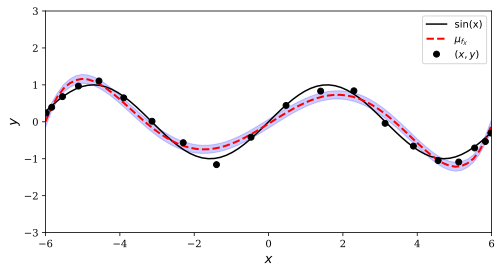

In [3]:
# Number of basis functions
M = 7

# Noise standard deviation
σ_noise = 0.1

# Prior mean and covariance for the weights
Σ_θ, μ_θ = np.eye(M), np.zeros(M)

# Define the basis, mean, and kernel functions
Phi = lambda x: np.polynomial.chebyshev.chebvander(x, M-1)
kernel = lambda x1, x2, Σ: Phi(x1) @ Σ @ Phi(x2).T
mean = lambda x, μ: Phi(x) @ μ

def BLR(x, y, X, Σ_θ, μ_θ, σ_noise):
    """
    Bayesian Linear Regression (BLR) with Gaussian prior and noise.
    
    Parameters:
    x, y : Training data
    X : Test data
    Σ_θ : Prior covariance matrix of the weights
    μ_θ : Prior mean of the weights
    σ_noise : Noise standard deviation
    
    Returns:
    μ_fX : Predictive mean at test points
    Σ_fX : Predictive covariance at test points
    """
    Σ_xx = kernel(x, x, Σ_θ) + (σ_noise**2) * np.eye(y.shape[0])
    Σ_xX = kernel(x, X, Σ_θ)
    Σ_XX = kernel(X, X, Σ_θ)

    P = np.linalg.solve(Σ_xx, Σ_xX).T
    μ_fX = mean(X, μ_θ) + P @ (y - mean(x, μ_θ))
    Σ_fX = Σ_XX - (P @ Σ_xX)

    return μ_fX, Σ_fX

# Define the true function
def f_real(x):
    return np.sin(x)

# Number of training and test data points
nx = 20
nX = 75

# Range for x and y values
x_range = (-6, 6)
y_range = (-3, 3)

# Generate Chebyshev collocation points
cheb_coll_points = lambda a, b, n: 0.5 * (a + b) + 0.5 * (b - a) * np.cos((2 * np.arange(n) + 1) * np.pi / (2 * n))

# Training data
x = cheb_coll_points(x_range[0], x_range[1], nx)
y = f_real(x) + σ_noise * np.random.normal(size=(nx,))

# Test data
X = np.linspace(x_range[0], x_range[1], nX)

# Perform Bayesian Linear Regression
μ_fX, Σ_fX = BLR(x, y, X, Σ_θ, μ_θ, σ_noise)

# Standard deviation of the predictive distribution
σ_fX = np.sqrt(np.diag(Σ_fX))

# Function to compute scaled Gaussian PDF for shading
def GaussPDFscaled(y, m, s):
    return np.exp(-0.5 * ((y.reshape(-1, 1) - m.reshape(1, -1)) / s.reshape(1, -1))**2)

# Plotting
fig, axs = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
axs.plot(X, f_real(X), 'k-', label='$\mathrm{sin(x)}$')
# axs.imshow(GaussPDFscaled(np.linspace(y_range[0], y_range[1], 500), μ_fX, σ_fX),
#            extent=[x_range[0], x_range[1], y_range[0], y_range[1]], aspect="auto", origin="lower", cmap="Blues", alpha=0.9)
axs.fill_between(X, μ_fX - 2*σ_fX, μ_fX + 2*σ_fX, color='b', alpha=0.2)
axs.plot(X, μ_fX, 'r--', lw=2, label=r'$\mu_{f_X}$')
axs.plot(x, y, 'ko', linewidth=2, label='$(x, y)$')
axs.set_xlabel('$x$', fontsize=13)
axs.set_ylabel('$y$', fontsize=13)
axs.axis([x_range[0], x_range[1], y_range[0], y_range[1]])
axs.legend()
plt.show()

# Gaussian Process Regression (GPR)

In Bayesian linear regression using features $\boldsymbol{\Phi}$, the mean vector and covariance matrix of the posterior predictive distribution for function values do not explicitly depend on the features themselves. Instead, they are expressed in terms of projections and inner products, of the form:

$$
m(\boldsymbol{x}) = \boldsymbol{\Phi}(\boldsymbol{x}) \boldsymbol{\mu}, \quad \text{and} \quad k(\boldsymbol{x}, \boldsymbol{X}) = \boldsymbol{\Phi}(\boldsymbol{x})^\top \boldsymbol{\Sigma}\, \boldsymbol{\Phi}(\boldsymbol{X}) = \sum_{i, j=1}^F \phi_i(x)\, \phi_j(X)\, \Sigma_{ij}
$$

These expressions define functions known as:

$$
\begin{array}{ll}
\text{Mean function:} & m: \mathbb{X} \rightarrow \mathbb{R} \\
\text{Covariance function:} & k: \mathbb{X} \times \mathbb{X} \rightarrow \mathbb{R}
\end{array}
$$

Because the features are encapsulated within these functions, it prompts the question of whether we can construct a Gaussian regression model without specifying an explicit set of features. For the mean function, this is straightforward: it can be any computationally tractable function $m$ $\boldsymbol{x}$: $\mathbb{X} \rightarrow \mathbb{R}$, not necessarily an inner product of feature functions.

The covariance function requires more careful consideration. By finding an analytic shortcut for the sum of $F^2$ terms with a clever choice of $\boldsymbol{\Phi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}$, we can effectively use a very large, even infinite set of features. This approach utilizes the **kernel trick**, which leverages certain structured sums and series in calculus that have analytic expressions, allowing computation without evaluating each term individually.

Consider $\mathbb{X} = \mathbb{R}$, and suppose we distribute Gaussian feature functions with scale $\lambda > 0$ regularly over the domain $$c_{\min}, c_{\max}$$ $\subset$ $\mathbb{R}$. Specifically, define:

$$
\phi_i( x ) = \exp \left( - \frac{ ( x - c_i )^2 }{ \lambda^2 } \right ), \quad c_i = c_{\min} + \frac{ i - 1 }{ F } ( c_{\max} - c_{\min} )
$$

We also choose the covariance matrix, for an arbitrary scale $\theta^2 > 0$, as:

$$
\boldsymbol{\Sigma} = \frac{ \sqrt{2}\, \theta^2\, ( c_{\max} - c_{\min} ) }{ \sqrt{ \pi }\, \lambda\, F }\, \boldsymbol{I}
$$

and set $\boldsymbol{\mu} = \boldsymbol{0}$. In the limit as $F \rightarrow \infty$, and $c_{\min} \rightarrow -\infty$, $c_{\max} \rightarrow \infty$, this yields:

$$
k( x, X ) = \theta^2\, \exp \left( - \frac{ ( x - X )^2 }{ 2\, \lambda^2 } \right )
$$

This is an example of a nonparametric regression formulation, where the model parameters are not explicitly represented in the computation, regardless of whether their number is finite or infinite. Remember, the **feature space is infinite**, but the **inner products remain finite**.

Common covariance functions (kernels) used in Gaussian processes include:

- **Radial Basis Function (RBF) kernel:**

$$
k( x_1, x_2 ) = \sigma^2\, \exp \left( - \frac{ \| x_1 - x_2 \|^2 }{ 2\, \ell^2 } \right )
$$

- **Exponential Sine Squared kernel:**

$$
k( x_1, x_2 ) = \sigma^2\, \exp \left( - \gamma\, \sin^2 \left( \pi\, \frac{ | x_1 - x_2 | }{ p } \right ) \right )
$$

In Gaussian Process Regression, we assume that the function $f x$ is drawn from a Gaussian process with mean function $m x$ and covariance function $k x, x'$, expressed as:

$$
f x \sim \mathcal{GP}( m x, k x, x' )
$$

Given observed data $$\boldsymbol{x}, \boldsymbol{y}$$, the posterior distribution over function values $f_X$ at test inputs $$\boldsymbol{X}$$ is:

$$
\begin{aligned}
\boldsymbol{\mu}_{ f_X } & = m( \boldsymbol{X} ) + k( \boldsymbol{X}, \boldsymbol{x} ) [ k( \boldsymbol{x}, \boldsymbol{x} ) + \boldsymbol{ \Lambda } ]^{-1} ( \boldsymbol{ y } - m( \boldsymbol{ x } ) ) \\
\boldsymbol{ \Sigma }_{ f_X } & = k( \boldsymbol{X}, \boldsymbol{X} ) - k( \boldsymbol{X}, \boldsymbol{x} ) [ k( \boldsymbol{x}, \boldsymbol{x} ) + \boldsymbol{ \Lambda } ]^{-1} k( \boldsymbol{x}, \boldsymbol{X} )
\end{aligned}
$$

Therefore, the predictive distribution is:

$$
p f_X | \boldsymbol{y} = \mathcal{N}( \boldsymbol{ \mu }_{ f_X }, \boldsymbol{ \Sigma }_{ f_X } )
$$

Gaussian Process Regression is a **nonparametric** approach, well-suited for modeling complex data that may not conform to a specific parametric form. While parametric models assume a particular functional form, which might not be appropriate for all datasets, nonparametric methods let the data determine the model structure. However, a key limitation of traditional nonparametric methods is that they typically require storing all training data, making them computationally inefficient for large datasets, as the number of parameters grows with the size of the data.

Deep learning offers a middle ground by combining the flexibility of nonparametric methods with the efficiency of parametric models, utilizing neural networks with a large but fixed number of parameters. Interestingly, it can be shown that a neural network with a single, infinitely wide layer of radial basis function RBF units equates to a Gaussian Process with an RBF kernel. In fact, many types of deep neural networks, in the infinite-width limit, can be described by Gaussian Processes using kernels such as the Neural Tangent Kernel (NTK).

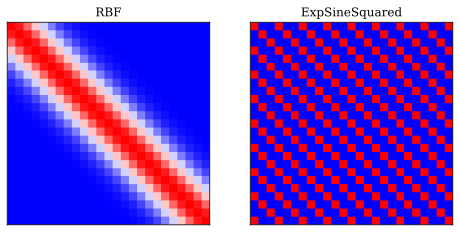

In [4]:
def RBF(x1, x2, kp):
    """
    Radial Basis Function (RBF) kernel.
    
    Parameters:
    x1, x2 : Input points
    kp : Kernel parameters [σ, l]
    
    Returns:
    Covariance matrix using the RBF kernel
    """
    σ, l = kp[0], kp[1]
    return σ**2 * kernels.ExpSquared(scale=l)(x1, x2)

def ExpSineSquared(x1, x2, kp):
    """
    Exponentiated Sine Squared kernel.
    
    Parameters:
    x1, x2 : Input points
    kp : Kernel parameters [σ, γ, p]
    
    Returns:
    Covariance matrix using the ExpSineSquared kernel
    """
    σ, γ, p = kp[0], kp[1], kp[2]
    return σ**2 * kernels.ExpSineSquared(scale=p, gamma=γ)(x1, x2)

# Generate input points
x = jnp.linspace(-4, 4, 25).reshape(-1, 1)

# Compute covariance matrices using the RBF and ExpSineSquared kernels
Σ_RBF = RBF(x, x, [1, 1])
Σ_ESS = ExpSineSquared(x, x, [1, 1, 1])

# Plot the covariance matrices
fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150)

# Plot for RBF kernel
axs[0].imshow(Σ_RBF, cmap='bwr')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("RBF")

# Plot for ExpSineSquared kernel
axs[1].imshow(Σ_ESS, cmap='bwr')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("ExpSineSquared")

plt.show()

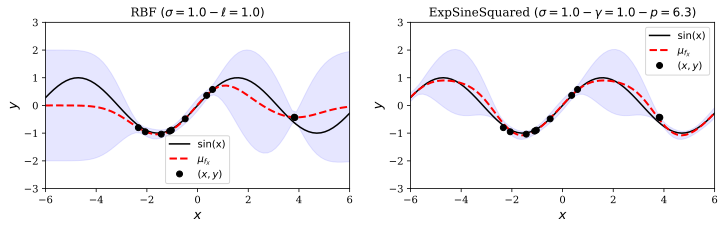

In [5]:
# Noise standard deviation
σ_noise = 0.1

# Mean function (zero mean)
mean = lambda x: jnp.zeros(x.shape[0])

def GP(x, y, X, kernel, kp):
    """
    Gaussian Process (GP) regression.
    
    Parameters:
    x, y : Training data
    X : Test data
    kernel : Kernel function
    kp : Kernel parameters
    
    Returns:
    μ_fX : Predictive mean at test points
    Σ_fX : Predictive covariance at test points
    """
    Σ_xx = kernel(x, x, kp) + (σ_noise**2) * jnp.eye(y.shape[0])
    Σ_xX = kernel(x, X, kp)
    Σ_XX = kernel(X, X, kp)

    P = jnp.linalg.solve(Σ_xx, Σ_xX).T

    μ_fX = mean(X) + P @ (y - mean(x))
    Σ_fX = Σ_XX - (P @ Σ_xX)

    return μ_fX, Σ_fX

# Random key for reproducibility
key = random.PRNGKey(42)

# Define the true function
def f_real(x):
    return jnp.sin(x).flatten()

# Number of training and test data points
nx = 10
nX = 75

# Range for x and y values
x_range = (-6, 6)
y_range = (-3, 3)

# Generate training data
x = random.uniform(key, minval=x_range[0] + 2, maxval=x_range[1] - 2, shape=(nx, 1))
y = f_real(x) + σ_noise * random.normal(key, shape=(nx,))

# Generate test data
X = jnp.linspace(x_range[0], x_range[1], nX).reshape(-1, 1)

# Kernel parameters for RBF and ExpSineSquared kernels
kp_RBF = [1, 1]
kp_ESS = [1, 1, 2 * jnp.pi]

# Perform GP regression with RBF kernel
μfX_RBF, ΣfX_RBF = GP(x, y, X, RBF, kp_RBF)

# Perform GP regression with ExpSineSquared kernel
μfX_ESS, ΣfX_ESS = GP(x, y, X, ExpSineSquared, kp_ESS)

# Standard deviation of the predictive distribution
σfX_RBF = jnp.sqrt(jnp.diag(ΣfX_RBF))
σfX_ESS = jnp.sqrt(jnp.diag(ΣfX_ESS))

# Function to compute scaled Gaussian PDF for shading
def GaussPDFscaled(y, m, s):
    return jnp.exp(-0.5 * ((y.reshape(-1, 1) - m.reshape(1, -1)) / s.reshape(1, -1))**2)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 3), dpi=100)

# Plot for RBF kernel
axs[0].plot(X, f_real(X), 'k-', label='$\mathrm{sin(x)}$')
# axs[0].imshow(GaussPDFscaled(jnp.linspace(y_range[0], y_range[1], 100), μfX_RBF, σfX_RBF),
#               extent=[x_range[0], x_range[1], y_range[0], y_range[1]], aspect="auto", origin="lower", cmap="Blues", alpha=0.9)
axs[0].fill_between(X.flatten(), μfX_RBF - 2 * σfX_RBF, μfX_RBF + 2 * σfX_RBF, color='b', alpha=0.1)
axs[0].plot(X, μfX_RBF, 'r--', lw=2, label=r'$\mu_{f_X}$')
axs[0].plot(x, y, 'ko', linewidth=2, label='$(x, y)$')
axs[0].set_xlabel('$x$', fontsize=13)
axs[0].set_ylabel('$y$', fontsize=13)
axs[0].set_title(f'RBF $( \sigma = {kp_RBF[0]:.1f} - \ell = {kp_RBF[1]:.1f})$')
axs[0].axis([x_range[0], x_range[1], y_range[0], y_range[1]])
axs[0].legend()

# Plot for ExpSineSquared kernel
axs[1].plot(X, f_real(X), 'k-', label='$\mathrm{sin(x)}$')
# axs[1].imshow(GaussPDFscaled(jnp.linspace(y_range[0], y_range[1], 100), μfX_ESS, σfX_ESS),
#               extent=[x_range[0], x_range[1], y_range[0], y_range[1]], aspect="auto", origin="lower", cmap="Blues", alpha=0.9)
axs[1].fill_between(X.flatten(), μfX_ESS - 2 * σfX_ESS, μfX_ESS + 2 * σfX_ESS, color='b', alpha=0.1)
axs[1].plot(X, μfX_ESS, 'r--', lw=2, label=r'$\mu_{f_X}$')
axs[1].plot(x, y, 'ko', linewidth=2, label='$(x, y)$')
axs[1].set_xlabel('$x$', fontsize=13)
axs[1].set_ylabel('$y$', fontsize=13)
axs[1].set_title(f'ExpSineSquared $( \sigma = {kp_ESS[0]:.1f} - \gamma = {kp_ESS[1]:.1f} - p = {kp_ESS[2]:.1f})$')
axs[1].axis([x_range[0], x_range[1], y_range[0], y_range[1]])
axs[1].legend()

plt.show()

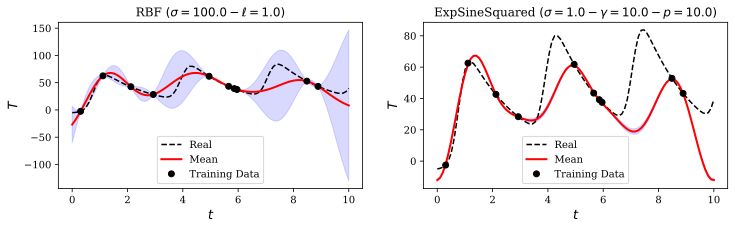

In [6]:
# Define the differential equation
def f(t, y):
    return -0.5 * y + jnp.exp(5 * jnp.sin(2 * t))

# Solve the differential equation
sol = solve_ivp(f, [0, 10], [-5], t_eval=jnp.linspace(0, 10, 100))

# Extract the solution
X = jnp.array(sol.t)
y_real = jnp.array(sol.y[0, :])

# Random key for reproducibility
key = random.PRNGKey(42)

# Select random training points
I = random.choice(key, X.shape[0], shape=(10,))
x = X[I]
y = y_real[I] + σ_noise * random.normal(key, shape=(I.shape[0],))

# Kernel parameters for RBF and ExpSineSquared kernels
kp_RBF = [100, 1]
kp_ESS = [1, 10, 10]

# Perform GP regression with RBF kernel
μfX_RBF, ΣfX_RBF = GP(x, y, X, RBF, kp_RBF)

# Perform GP regression with ExpSineSquared kernel
μfX_ESS, ΣfX_ESS = GP(x, y, X, ExpSineSquared, kp_ESS)

# Standard deviation of the predictive distribution
σfX_RBF = jnp.sqrt(jnp.diag(ΣfX_RBF))
σfX_ESS = jnp.sqrt(jnp.diag(ΣfX_ESS))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 3), dpi=100)

# Plot for RBF kernel
axs[0].plot(X, y_real, 'k--', label='Real')
axs[0].fill_between(X, μfX_RBF - 2 * σfX_RBF, μfX_RBF + 2 * σfX_RBF, color='b', alpha=0.15)
axs[0].plot(X, μfX_RBF, 'r-', lw=2, label='Mean')
axs[0].plot(x, y, 'ko', linewidth=2, label='Training Data')
axs[0].set_xlabel('$t$', fontsize=13)
axs[0].set_ylabel('$T$', fontsize=13)
axs[0].set_title(f'RBF $( \sigma = {kp_RBF[0]:.1f} - \ell = {kp_RBF[1]:.1f})$')
axs[0].legend()

# Plot for ExpSineSquared kernel
axs[1].plot(X, y_real, 'k--', label='Real')
axs[1].fill_between(X, μfX_ESS - 2 * σfX_ESS, μfX_ESS + 2 * σfX_ESS, color='b', alpha=0.15)
axs[1].plot(X, μfX_ESS, 'r-', lw=2, label='Mean')
axs[1].plot(x, y, 'ko', linewidth=2, label='Training Data')
axs[1].set_xlabel('$t$', fontsize=13)
axs[1].set_ylabel('$T$', fontsize=13)
axs[1].set_title(f'ExpSineSquared $( \sigma = {kp_ESS[0]:.1f} - \gamma = {kp_ESS[1]:.1f} - p = {kp_ESS[2]:.1f})$')
axs[1].legend()

plt.show()

By using the exponential sine squared kernel in our Gaussian Process Regression model, we observe better predictive results compared to the radial basis function RBF kernel. This improvement arises because the sine squared kernel more closely matches the characteristics of our target function. Specifically, the sine squared kernel is inherently periodic, making it well-suited for modeling data with periodic behavior.

At the training data points, the predicted or fitted function matches the true function exactly. However, in regions where training data is absent, the predictions exhibit uncertainty. An important consideration is the selection of kernel parameters, such as $\sigma$, $\gamma$, and $p$ in the sine squared kernel, and $\sigma$ and $\ell$ in the RBF kernel. These parameters significantly influence the predictions and should be carefully chosen, often through techniques like cross-validation or optimization methods.

## Constructing New Kernels from Existing Ones

Given two valid kernels $\mathcal{K}_1(\boldsymbol{x}, \boldsymbol{x}^\prime)$ and $\mathcal{K}_2(\boldsymbol{x}, \boldsymbol{x}^\prime)$, we can create new kernels using the following operations:

1. **Sum of kernels:**

   $$
   \mathcal{K}(\boldsymbol{x}, \boldsymbol{x}^\prime) = \mathcal{K}_1(\boldsymbol{x}, \boldsymbol{x}^\prime) + \mathcal{K}_2(\boldsymbol{x}, \boldsymbol{x}^\prime)
   $$

2. **Product of kernels:**

   $$
   \mathcal{K}(\boldsymbol{x}, \boldsymbol{x}^\prime) = \mathcal{K}_1(\boldsymbol{x}, \boldsymbol{x}^\prime) \times \mathcal{K}_2(\boldsymbol{x}, \boldsymbol{x}^\prime)
   $$

3. **Scaling by a positive constant $c > 0$:**

   $$
   \mathcal{K}(\boldsymbol{x}, \boldsymbol{x}^\prime) = c \cdot \mathcal{K}_1(\boldsymbol{x}, \boldsymbol{x}^\prime)
   $$

4. **Multiplying by functions at each point:**

   $$
   \mathcal{K}(\boldsymbol{x}, \boldsymbol{x}^\prime) = f(\boldsymbol{x}) \cdot \mathcal{K}_1(\boldsymbol{x}, \boldsymbol{x}^\prime) \cdot f(\boldsymbol{x}^\prime)
   $$

   where $f(\boldsymbol{x})$ is any real-valued function.

5. **Applying a polynomial with non-negative coefficients:**

   $$
   \mathcal{K}(\boldsymbol{x}, \boldsymbol{x}^\prime) = q\left( \mathcal{K}_1(\boldsymbol{x}, \boldsymbol{x}^\prime) \right)
   $$

   where $q$ is any polynomial with non-negative coefficients.

6. **Exponentiating a kernel:**

   $$
   \mathcal{K}(\boldsymbol{x}, \boldsymbol{x}^\prime) = \exp\left( \mathcal{K}_1(\boldsymbol{x}, \boldsymbol{x}^\prime) \right)
   $$

7. **Linear kernel with a positive semidefinite matrix $\mathbf{A}$:**

   $$
   \mathcal{K}(\boldsymbol{x}, \boldsymbol{x}^\prime) = \boldsymbol{x}^\top \mathbf{A} \boldsymbol{x}^\prime
   $$

These operations allow us to build new kernels that inherit properties from the original kernels, enabling flexible modeling of complex data patterns.

## Scaling Gaussian Processes to Large Datasets

A major limitation of Gaussian Processes (GPs) is the computational cost associated with inverting the $N \times N$ kernel matrix, which requires $O(N^3)$ time. This operation becomes impractical for large datasets. To address this issue, various approximation methods have been developed to make GPs more scalable.

### Sparse Gaussian Process Regression

One straightforward method to accelerate GP inference is to use fewer data points. However, a more effective approach is to **summarize** the $N$ training points $\mathbf{X}$ into a set of $M \ll N$ inducing points or pseudo-inputs $\mathbf{Z}$. This allows us to approximate $ the conditional distribution $ $p(\boldsymbol{f} \mid \boldsymbol{f}_X)$ with $p(\boldsymbol{f} \mid \boldsymbol{f}_Z)$, where:

- $\boldsymbol{f}_X = \{ f(\boldsymbol{x}) : \boldsymbol{x} \in \mathbf{X} \}$ represents the function values at the original training points.
- $\boldsymbol{f}_Z = \{ f(\boldsymbol{z}) : \boldsymbol{z} \in \mathbf{Z} \}$ represents the function values at the inducing points.

By optimizing over $\mathbf{Z}$ and $\boldsymbol{f}_Z$, we effectively **compress** the training data into a lower-dimensional **bottleneck** representation. This reduces the computational complexity from $O(N^3)$ to $O(M^3)$, where $M$ is much smaller than $N$. This approach is known as sparse Gaussian Process regression.

For standard GP regression, the computational complexity is $O(N^3)$, and the storage requirement is $O(N^2)$. In contrast, sparse GP regression reduces the computational complexity to $O(NM^2)$ and the storage requirement to $O(NM)$.

The kernel matrix $K$ is approximated as:

$$
K_{N \times N} \approx K_{N \times M} \, K_{M \times M}^{-1} \, K_{M \times N}
$$

where:

- $K_{N \times M}$ is the kernel matrix between the training data and the inducing points.
- $K_{M \times M}$ is the kernel matrix between the inducing points themselves.
- $K_{M \times N}$ is the kernel matrix between the inducing points and the training data.

### Exploiting Parallelization $$ Kernel Matrix Structure

An alternative to Cholesky decomposition for solving the system of linear equations involved in GP inference is to use Krylov subspace methods, such as the conjugate gradient method. These iterative algorithms rely solely on matrix-vector multiplications, which can be significantly faster, especially when exploiting the structure of the kernel matrix.

Moreover, even when the kernel matrix lacks special structure, matrix-vector multiplications are easily parallelizable and can leverage modern hardware accelerations, such as GPUs. In contrast, Cholesky decomposition is inherently sequential and less amenable to parallelization.

### Random Feature Approximations

While the strength of kernel methods lies in avoiding explicit feature representations, we can approximate the feature mapping for many shift-invariant kernels using a finite set of $M$ randomly chosen basis functions. This technique reduces the computational cost to $O(NM + M^3)$.

Methods such as **Random Fourier Features** approximate the kernel function by mapping the inputs into a lower-dimensional feature space using random projections. This allows us to approximate the kernel matrix efficiently and make Gaussian Process regression scalable to larger datasets.

# Markov Chains and Message Passing

As discussed in the Gaussian Process Regression (GPR) section, GPR provides a general framework for inferring functions from a finite set of data points. However, computing the posterior parameters for $N$ real-valued data points requires $\mathcal{O}(N^3)$ computational cost due to the inversion of the $N \times N$ kernel matrix. Ideally, we desire algorithms that can run indefinitely, improving precision over time, with computational complexity scaling at most linearly, $\mathcal{O}(N)$.

Certain numerical problems offer an alternative approach to address this challenge. They construct an ordered sequence of estimates by progressing along a one-dimensional path parameterized by a variable $t$, which we can interpret as time. Central examples of such problems include quadrature, ordinary differential equations (ODEs), and optimization. This concept of having finite memory through time is formalized by the **Markov property**.

## Markov Chain

Consider a discrete set of latent variables, known as states, denoted by $X = \{ x_t \}_{t=0}^{T}$, with joint probability density $p(X)$. The sequence $X$ forms a **Markov chain** if it satisfies the Markov property, meaning that each state $x_t$ is conditionally independent of all preceding states given the immediate predecessor $x_{t-1}$:

$$
p(x_t \mid x_0, x_1, \ldots, x_{t-1}) = p(x_t \mid x_{t-1}).
$$

In other words, the state $x_t$ encapsulates all necessary information from the past to predict the future behavior of the system at time $t$. Additionally, assume we have observations $y_t$ that relate directly to the local state $x_t$:

$$
p(y_t \mid X) = p(y_t \mid x_t).
$$

These two structural assumptions simplify inference on the latent variables, allowing it to scale linearly with $T$. Specifically, we can iteratively compute the posterior over $x_t$ given all previous observations by alternating between **prediction** and **update** steps that involve only local computations.

**Predict:** Update the belief about the next state using the posterior from the previous step:

$$
p(x_t \mid \boldsymbol{y}_{0:t-1}) = \int p(x_t \mid x_{t-1})\, p(x_{t-1} \mid \boldsymbol{y}_{0:t-1})\, \mathrm{d} x_{t-1}.
$$

For $t = 0$, we start with the prior distribution $p(x_0)$. This expression is known as the **Chapman–Kolmogorov equation**.

**Update:** Incorporate the new observation into the posterior using Bayes' theorem:

$$
p(x_t \mid \boldsymbol{y}_{0:t}) = \frac{ p(y_t \mid x_t) \, p(x_t \mid \boldsymbol{y}_{0:t-1}) }{ \int p(y_t \mid x_t) \, p(x_t \mid \boldsymbol{y}_{0:t-1})\, \mathrm{d} x_t }.
$$

When we have all observations $\boldsymbol{y} = \boldsymbol{y}_{0:T}$ and need to compute the marginal distribution $p(x_t \mid \boldsymbol{y})$ for some $0 \leq t \leq T$, the situation becomes slightly more complex:

$$
p(x_t \mid \boldsymbol{y}) = p(x_t \mid \boldsymbol{y}_{0:t}) \int p(x_{t+1} \mid x_t) \frac{ p(x_{t+1} \mid \boldsymbol{y}) }{ p(x_{t+1} \mid \boldsymbol{y}_{0:t}) }\, \mathrm{d} x_{t+1}.
$$

To compute the marginals $p(x_t \mid \boldsymbol{y})$ for all $0 \leq t \leq T$, we perform a **forward pass**, computing the predictions $p(x_t \mid \boldsymbol{y}_{0:t-1})$ and updated beliefs $p(x_t \mid \boldsymbol{y}_{0:t})$. The final update provides $p(x_T \mid \boldsymbol{y})$, from which we initiate a **backward pass** to compute the posterior marginals $p(x_t \mid \boldsymbol{y})$ utilizing the results from the forward pass.

In signal processing, where time series are pivotal, the forward pass is referred to as **filtering**, while the backward updates are known as **smoothing**.

## Kálmán Filter

Assuming linear Gaussian models, we define the following distributions using common notation for the involved linear transformations:

$$
\begin{aligned}
p(x_0) & = \mathcal{N}( x_0; \, m_0, \, P_0 ), \\
p(x_{t+1} \mid x_t) & = \mathcal{N}( x_{t+1}; \, A_t x_t, \, Q_t ), \\
p(y_t \mid x_t) & = \mathcal{N}( y_t; \, H_t x_t, \, R_t ).
\end{aligned}
$$

The second and third equations are often expressed as the **dynamic model** and the **measurement model**, respectively:

$$
\begin{aligned}
& \text{Dynamic model:} \quad x_{t+1} = A_t x_t + \xi_t, \quad \text{with} \quad \xi_t \sim \mathcal{N}(0, \, Q_t), \\
& \text{Measurement model:} \quad y_t = H_t x_t + \zeta_t, \quad \text{with} \quad \zeta_t \sim \mathcal{N}(0, \, R_t).
\end{aligned}
$$

In signal processing and control theory, $A_t$ and $H_t$ are known as the **transition** and **measurement** matrices, while $Q_t$ and $R_t$ are the **process noise** and **observation noise** covariances, respectively.

With these assumptions, the predictive and updated posterior distributions remain Gaussian. The **prediction** step using the Chapman–Kolmogorov equation becomes:

$$
\begin{aligned}
p(x_{t+1} \mid \boldsymbol{y}_{0:t}) = \mathcal{N}( x_{t+1}; \, m_{t+1}^{-}, \, P_{t+1}^{-} ), \quad \text{where} \\
m_{t+1}^{-} = A_t m_t, \quad \text{and} \quad P_{t+1}^{-} = A_t P_t A_t^\top + Q_t.
\end{aligned}
$$

The **update** step incorporates the new observation:

$$
p(x_t \mid \boldsymbol{y}_{0:t}) = \mathcal{N}( x_t; \, m_t, \, P_t ),
$$

where the parameters are calculated as follows, assigning specific names to intermediate terms:

$$
\begin{aligned}
K_t &= P_t^{-} H_t^\top S_t^{-1}, \quad \text{(Kalman gain)} \\
m_t &= m_t^{-} + K_t z_t, \\
P_t &= (I - K_t H_t) P_t^{-},
\end{aligned}
$$

with

$$
\begin{aligned}
z_t &= y_t - H_t m_t^{-}, \quad \text{(innovation residual)} \\
S_t &= H_t P_t^{-} H_t^\top + R_t, \quad \text{(innovation covariance)}.
\end{aligned}
$$

The complete prediction-update scheme is widely known as the **Kálmán filter**, and $K_t$ is called the **Kalman gain**.

The **full posterior marginals**, considering all observations from the past and the future, are also Gaussian:

$$
p(x_t \mid \boldsymbol{y}) = \mathcal{N}( x_t; \, m_t^{s}, \, P_t^{s} ).
$$

These parameters can be computed using the **Kalman smoother** equations:

$$
\begin{aligned}
\text{Let} \quad G_t &= P_t A_t^\top (P_{t+1}^{-})^{-1}, \quad \text{(smoother gain)} \\
\text{then} \quad m_t^{s} &= m_t + G_t ( m_{t+1}^{s} - m_{t+1}^{-} ), \\
P_t^{s} &= P_t + G_t ( P_{t+1}^{s} - P_{t+1}^{-} ) G_t^\top.
\end{aligned}
$$

For a finite time series from $t = 0$ to $t = T$, this algorithm returns posterior marginals at every time step $t$. Importantly, these marginals (specifically, their means and variances) are exactly equivalent to those obtained from Gaussian Process Regression with Markov priors. Therefore, **this algorithm provides a linear-time implementation of GPR utilizing Markov properties**. While the runtime is linear in $T$, it requires linearly growing memory to store all the parameters of the posterior and intermediate distributions.

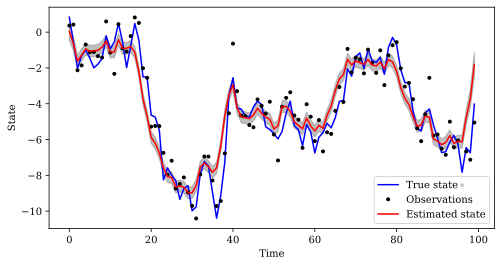

In [7]:
def filter(m_prev, P_prev, A, Q, H, R, y):
    """
    Kalman filter step.
    
    Parameters:
    m_prev : Previous mean
    P_prev : Previous covariance
    A : State transition matrix
    Q : Process noise covariance
    H : Observation matrix
    R : Observation noise covariance
    y : Observation
    
    Returns:
    (m, P) : Updated mean and covariance
    (m_pred, P_pred) : Predicted mean and covariance
    """
    m_pred = A @ m_prev                   # Predictive mean
    P_pred = A @ P_prev @ A.T + Q         # Predictive covariance
    z = y - H @ m_pred                    # Residual
    S = H @ P_pred @ H.T + R              # Innovation covariance
    K = P_pred @ H.T @ np.linalg.inv(S)   # Kalman gain
    m = m_pred + K @ z                    # Updated mean
    P = (np.eye(len(m)) - K @ H) @ P_pred # Updated covariance

    return (m, P), (m_pred, P_pred)

def smoother(m, P, A, m_pred_next, P_pred_next, m_s_next, P_s_next):
    """
    Kalman smoother step.
    
    Parameters:
    m, P : Current mean and covariance
    A : State transition matrix
    m_pred_next, P_pred_next : Next predicted mean and covariance
    m_s_next, P_s_next : Next smoothed mean and covariance
    
    Returns:
    m_s, P_s : Smoothed mean and covariance
    """
    G = P @ A.T @ np.linalg.inv(P_pred_next)     # Smoothing gain
    m_s = m + G @ (m_s_next - m_pred_next)       # Smoothed mean
    P_s = P + G @ (P_s_next - P_pred_next) @ G.T # Smoothed covariance

    return m_s, P_s

def infer(m_0, P_0, params):
    """
    Perform Kalman filtering and smoothing.
    
    Parameters:
    m_0 : Initial mean
    P_0 : Initial covariance
    params : List of tuples (A, Q, H, y, R) for each time step
    
    Returns:
    lm_s, lP_s : Smoothed means and covariances
    """
    m, P = m_0, P_0
    m_pred, P_pred = m_0, P_0
    m_s, P_s = m_0, P_0

    lm, lP, lm_pred, lP_pred, lm_s, lP_s = [], [], [], [], [], []

    T = len(params)
    # Forward pass (Kalman filter)
    for t in range(T):
        A, Q, H, y, R = params[t]
        (m, P), (m_pred, P_pred) = filter(m, P, A, Q, H, R, y)

        lm.append(m.copy())
        lP.append(P.copy())
        lm_pred.append(m_pred.copy())
        lP_pred.append(P_pred.copy())

    # Backward pass (Kalman smoother)
    for t in range(T-1, -1, -1):
        A, _, _, _, _ = params[t]
        m_s, P_s = smoother(lm[t], lP[t], A, lm_pred[t], lP_pred[t], m_s, P_s)

        lm_s.append(m_s.copy())
        lP_s.append(P_s.copy())
        
    return np.array(lm_s[::-1]).ravel(), np.array(lP_s[::-1]).ravel()

# Define the system parameters
A = np.array([[1]])  # State transition matrix
Q = np.array([[0.1]])  # Process noise covariance
H = np.array([[1]])  # Observation matrix
R = np.array([[0.5]])  # Observation noise covariance
m_0 = np.array([0])  # Initial mean
P_0 = np.array([[1]])  # Initial covariance

# Generate some synthetic data
T = 100
true_state = np.cumsum(np.random.normal(size=T))  # True state
observations = true_state + np.random.normal(scale=np.sqrt(R[0, 0]), size=T)  # Observations

# Apply the Kalman filter and smoother
params = [(A, Q, H, np.array([y]), R) for y in observations]
m, P = infer(m_0, P_0, params)

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(true_state, 'b', label='True state')
plt.plot(observations, 'k.', label='Observations')
plt.plot(m, 'r', label='Estimated state')
plt.fill_between(np.arange(T), m - np.sqrt(P), m + np.sqrt(P), color='gray', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

# Maximum Likelihood Estimation (MLE)

Maximum Likelihood Estimation is a method used to determine the parameters of a probability distribution that maximize the likelihood of observing the given data. The **likelihood** is the probability of the data given the parameters of the distribution. It measures how well the model explains the observed data. The parameters to be estimated are the model parameters, which are not fixed and are learned from the data.

The Maximum Likelihood Estimator is defined as:

$$
\hat{\boldsymbol{\theta}}_{\text{MLE}} \triangleq \underset{\boldsymbol{\theta}}{\operatorname{argmax}}\, p(\mathcal{D} \mid \boldsymbol{\theta})
$$

We typically assume that the training examples are independently and identically distributed (i.i.d)., meaning each sample is drawn independently from the same distribution. Under this assumption, the conditional likelihood becomes:

$$
p(\mathcal{D} \mid \boldsymbol{\theta}) = \prod_{n=1}^N p(\boldsymbol{y}_n \mid \boldsymbol{x}_n, \boldsymbol{\theta})
$$

In practice, it is more convenient to maximize the **log-likelihood** function. Since the logarithm is a monotonically increasing function, maximizing the log-likelihood is equivalent to maximizing the likelihood itself. Taking the logarithm simplifies the mathematical analysis and addresses numerical issues, as multiplying many small probabilities can lead to numerical underflow. Converting to log-probabilities allows us to sum instead of multiply:

$$
LL(\boldsymbol{\theta}) \triangleq \log p(\mathcal{D} \mid \boldsymbol{\theta}) = \sum_{n=1}^N \log p(\boldsymbol{y}_n \mid \boldsymbol{x}_n, \boldsymbol{\theta})
$$

This expression decomposes into a sum of terms, one for each example. Therefore, the Maximum Likelihood Estimator becomes:

$$
\hat{\boldsymbol{\theta}}_{\text{MLE}} = \underset{\boldsymbol{\theta}}{\operatorname{argmax}} \sum_{n=1}^N \log p(\boldsymbol{y}_n \mid \boldsymbol{x}_n, \boldsymbol{\theta})
$$

Since many optimization algorithms are formulated to **minimize** a cost function, we can redefine the objective function as the conditional **negative log-likelihood (NLL)**:

$$
NLL(\boldsymbol{\theta}) \triangleq -\log p(\mathcal{D} \mid \boldsymbol{\theta}) = -\sum_{n=1}^N \log p(\boldsymbol{y}_n \mid \boldsymbol{x}_n, \boldsymbol{\theta})
$$

Minimizing the NLL yields the Maximum Likelihood Estimate. If the model is unconditional unsupervised, where there are outputs $\boldsymbol{y}_n$ but no inputs $\boldsymbol{x}_n$, the MLE becomes:

$$
\hat{\boldsymbol{\theta}}_{\text{MLE}} = \underset{\boldsymbol{\theta}}{\operatorname{argmin}} -\sum_{n=1}^N \log p(\boldsymbol{y}_n \mid \boldsymbol{\theta})
$$

# Empirical Risk Minimization (ERM)

We can generalize Maximum Likelihood Estimation (MLE) by replacing the conditional log-loss term, $\ell\left( \boldsymbol{y}_n,\, \boldsymbol{\theta};\, \boldsymbol{x}_n \right) = -\log p\left( \boldsymbol{y}_n \mid \boldsymbol{x}_n,\, \boldsymbol{\theta} \right)$, with any other loss function:

$$
\mathcal{L}( \boldsymbol{\theta} ) = \frac{1}{N} \sum_{n=1}^N \ell\left( \boldsymbol{y}_n,\, \boldsymbol{\theta};\, \boldsymbol{x}_n \right)
$$

We then minimize this loss to determine the model parameters:

$$
\hat{\boldsymbol{\theta}} = \underset{\boldsymbol{\theta}}{ \operatorname{argmin} } \mathcal{L}( \boldsymbol{\theta} )
$$

This approach is known as **Empirical Risk Minimization (ERM)**. In regression analysis, the most common choice of loss function is the $\ell_2$ loss. However, if the data contains outliers, the quadratic penalty might be excessively harsh. In such cases, using the $\ell_1$ loss function can provide a more robust alternative.

The $\ell_2$ loss function is defined as:

$$
\ell_2( y,\, \hat{y} ) = ( y - \hat{y} )^2
$$

This loss penalizes large residuals $y - \hat{y}$ more severely than smaller ones. When using the quadratic loss, the empirical risk becomes equivalent to the Mean Squared Error (MSE):

$$
\operatorname{MSE}( \boldsymbol{\theta} ) = \frac{1}{N} \sum_{n=1}^N \left( y_n - f\left( \boldsymbol{x}_n;\, \boldsymbol{\theta} \right) \right)^2
$$

# Maximum A Posteriori Estimation (MAP) - Regularization

A fundamental issue with Maximum Likelihood Estimation (MLE) and Empirical Risk Minimization (ERM) is that they aim to select parameters that minimize the loss on the training data, which can lead to **overfitting**. Overfitting happens when a model learns the training data too well, including its noise, and fails to generalize to new, unseen data. This typically occurs when the model has enough capacity to perfectly fit the training data, matching the empirical distribution exactly. However, the empirical distribution derived from the finite training set may not represent the true underlying distribution. As a result, allocating all probability mass to the observed $N$ examples leaves no probability for new data, hindering the model's ability to generalize.

To mitigate overfitting, we employ **regularization**, which involves adding a penalty term to the Negative Log-Likelihood (NLL) (or empirical risk). The regularized objective function becomes:

$$
\mathcal{L}(\boldsymbol{\theta}; \lambda) = \frac{1}{N} \sum_{n=1}^N \ell\left( \boldsymbol{y}_n,\, \boldsymbol{\theta};\, \boldsymbol{x}_n \right) + \lambda C(\boldsymbol{\theta})
$$

where $\lambda \geq 0$ is the regularization parameter, and $C(\boldsymbol{\theta})$ is a complexity penalty that discourages overly complex models.

A common choice for the complexity penalty is to set $C(\boldsymbol{\theta}) = -\log p(\boldsymbol{\theta})$, where $p(\boldsymbol{\theta})$ represents a prior distribution over the parameters. If we use the log-loss $\ell$ (i.e., $\ell = -\log p(\boldsymbol{y}_n \mid \boldsymbol{x}_n,\, \boldsymbol{\theta})$), the regularized objective becomes:

$$
\mathcal{L}(\boldsymbol{\theta}; \lambda) = -\frac{1}{N} \sum_{n=1}^N \log p\left( \boldsymbol{y}_n \mid \boldsymbol{x}_n,\, \boldsymbol{\theta} \right) - \lambda \log p(\boldsymbol{\theta})
$$

By setting $\lambda = 1$ and appropriately adjusting the prior $p(\boldsymbol{\theta})$, we simplify the objective to:

$$
\mathcal{L}(\boldsymbol{\theta}) = -\left[ \sum_{n=1}^N \log p\left( \boldsymbol{y}_n \mid \boldsymbol{x}_n,\, \boldsymbol{\theta} \right) + \log p(\boldsymbol{\theta}) \right] = -\left[ \log p(\mathcal{D} \mid \boldsymbol{\theta}) + \log p(\boldsymbol{\theta}) \right]
$$

Minimizing this objective is equivalent to maximizing the log-posterior distribution:

$$
\hat{\boldsymbol{\theta}} = \underset{\boldsymbol{\theta}}{\operatorname{argmax}}\, \log p\left( \boldsymbol{\theta} \mid \mathcal{D} \right) = \underset{\boldsymbol{\theta}}{\operatorname{argmax}}\, \left[ \log p(\mathcal{D} \mid \boldsymbol{\theta}) + \log p(\boldsymbol{\theta}) - \text{const} \right]
$$

This approach is known as **Maximum a Posteriori Estimation (MAP)**.

# Information Theory

## Entropy

Let's begin by considering a discrete random variable $ x $ and explore how much information is gained when observing a specific value of this variable. The amount of information can be thought of as the "degree of surprise" upon learning the outcome of $ x $. An unlikely event carries more information than a likely one, and an event that is certain to occur conveys no information at all. Therefore, the information content should depend on the probability distribution $ p(x) $.

We define the information content of a specific outcome $ x $ as:

$$
h(x) = -\log_2 p(x)
$$

This function is monotonic in $ p(x) $ and captures the notion that lower probability events are more informative.

The **entropy** of the random variable $ x $ is then defined as the expected value of the information content:

$$
\mathrm{H}[x] = -\sum_x p(x) \log_2 p(x)
$$

As an example, consider a random variable $ x $ with eight possible states, each equally likely. To communicate the value of $ x $ to a receiver, we would need to transmit a message of length 3 bits (since $ 2^3 = 8 $). The entropy of this uniform distribution is:

$$
\mathrm{H}[x] = -8 \times \frac{1}{8} \log_2 \frac{1}{8} = -1 \times \log_2 \frac{1}{8} = 3 \text{ bits}
$$

Now consider another random variable with the same eight states $ \{a, b, c, d, e, f, g, h\} $, but with probabilities $ \left( \frac{1}{2}, \frac{1}{4}, \frac{1}{8}, \frac{1}{16}, \frac{1}{64}, \frac{1}{64}, \frac{1}{64}, \frac{1}{64} \right) $. The entropy in this case is:

$$
\begin{aligned}
\mathrm{H}[x] &= -\left( \frac{1}{2} \log_2 \frac{1}{2} + \frac{1}{4} \log_2 \frac{1}{4} + \frac{1}{8} \log_2 \frac{1}{8} + \frac{1}{16} \log_2 \frac{1}{16} + 4 \times \frac{1}{64} \log_2 \frac{1}{64} \right) \\
&= -\left( \frac{1}{2} \times (-1) + \frac{1}{4} \times (-2) + \frac{1}{8} \times (-3) + \frac{1}{16} \times (-4) + 4 \times \left( \frac{1}{64} \times (-6) \right) \right) \\
&= \left( \frac{1}{2} + \frac{1}{2} + \frac{3}{8} + \frac{1}{4} + \frac{3}{8} \right) \\
&= 2 \text{ bits}
\end{aligned}
$$

This example illustrates that a non-uniform distribution has a lower entropy than a uniform distribution over the same number of states.

For a continuous random variable $ x $ with probability density function $ p(x) $, the **differential entropy** is defined as:

$$
\mathrm{H}[x] = -\int p(x) \ln p(x) \, \mathrm{d}x
$$

The distribution that maximizes differential entropy under certain constraints is the Gaussian distribution. The differential entropy of the Gaussian distribution $ \mathcal{N}(\mu, \sigma^2) $ is:

$$
\mathrm{H}[x] = \frac{1}{2} \left( 1 + \ln \left( 2\pi \sigma^2 \right) \right)
$$

We observe that the entropy increases as the variance $ \sigma^2 $ increases, indicating that broader distributions have higher entropy. Notably, unlike discrete entropy, differential entropy can be negative when $ \sigma^2 < \frac{1}{2\pi e} $.

### Conditional Entropy

Consider two sets of variables $ \mathbf{x} $ and $ \mathbf{y} $ with a joint distribution $ p(\mathbf{x}, \mathbf{y}) $. If we know the value of $ \mathbf{x} $, the additional information needed to specify $ \mathbf{y} $ is given by the conditional entropy:

$$
\mathrm{H}[\mathbf{y} \mid \mathbf{x}] = -\iint p(\mathbf{x}, \mathbf{y}) \ln p(\mathbf{y} \mid \mathbf{x}) \, \mathrm{d}\mathbf{y} \, \mathrm{d}\mathbf{x}
$$

Using the chain rule of entropy, we have:

$$
\mathrm{H}[\mathbf{x}, \mathbf{y}] = \mathrm{H}[\mathbf{x}] + \mathrm{H}[\mathbf{y} \mid \mathbf{x}]
$$

This relation shows that the total information needed to describe both $ \mathbf{x} $ and $ \mathbf{y} $ is the sum of the information needed for $ \mathbf{x} $ and the additional information needed for $ \mathbf{y} $ given $ \mathbf{x} $.

## Kullback-Leibler (KL) Divergence

Suppose we have an unknown probability distribution $ p(\mathbf{x}) $ that we wish to approximate with a distribution $ q(\mathbf{x}) $. If we use $ q(\mathbf{x}) $ for encoding values of $ \mathbf{x} $, the average additional information required due to the discrepancy between $ p $ and $ q $ is quantified by the **Kullback-Leibler (KL) divergence**:

$$
\begin{aligned}
\mathrm{KL}(p \| q) &= -\int p(\mathbf{x}) \ln q(\mathbf{x}) \, \mathrm{d}\mathbf{x} + \int p(\mathbf{x}) \ln p(\mathbf{x}) \, \mathrm{d}\mathbf{x} \\
&= \int p(\mathbf{x}) \ln \frac{p(\mathbf{x})}{q(\mathbf{x})} \, \mathrm{d}\mathbf{x}
\end{aligned}
$$

The KL divergence measures the difference between the two distributions and is always non-negative. It is important to note that $ \mathrm{KL}(p \| q) \neq \mathrm{KL}(q \| p) $; the divergence is not symmetric.

In the context of data compression and density estimation, using $ q(\mathbf{x}) $ instead of the true distribution $ p(\mathbf{x}) $ leads to less efficient encoding. The average additional bits required per message are at least equal to the KL divergence between $ p $ and $ q $.

When we have a set of observed data points $ \{\mathbf{x}_n\}_{n=1}^N $ drawn from $ p(\mathbf{x}) $, we can approximate the KL divergence using the sample mean:

$$
\mathrm{KL}(p \| q) \approx \frac{1}{N} \sum_{n=1}^N \left( \ln p(\mathbf{x}_n) - \ln q(\mathbf{x}_n \mid \boldsymbol{\theta}) \right)
$$

Since $ p(\mathbf{x}_n) $ is unknown and independent of $ \boldsymbol{\theta} $, minimizing the KL divergence with respect to $ \boldsymbol{\theta} $ is equivalent to maximizing the log-likelihood of the observed data under the model $ q(\mathbf{x} \mid \boldsymbol{\theta}) $:

$$
\text{Maximize } \sum_{n=1}^N \ln q(\mathbf{x}_n \mid \boldsymbol{\theta})
$$

**Therefore, minimizing the KL divergence is equivalent to maximum likelihood estimation.**

### KL Divergence Between Multivariate Gaussian Distributions

Consider two multivariate Gaussian distributions:

- $ p(\mathbf{x}) = \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_p, \boldsymbol{\Sigma}_p) $
- $ q(\mathbf{x}) = \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_q, \boldsymbol{\Sigma}_q) $

The Kullback-Leibler (KL) divergence from distribution $ q $ to $ p $ is defined as:

$$
\mathrm{KL}(p \| q) = \int p(\mathbf{x}) \ln \left( \dfrac{p(\mathbf{x})}{q(\mathbf{x})} \right) \, d\mathbf{x}
$$

Alternatively, we can express it using the expectation with respect to $ p(\mathbf{x}) $:

$$
\mathrm{KL}(p \| q) = \mathbb{E}_{p(\mathbf{x})} \left[ \ln p(\mathbf{x}) - \ln q(\mathbf{x}) \right]
$$

#### Derivation of the KL Divergence

First, recall the logarithm of a multivariate Gaussian density:

$$
\ln \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}, \boldsymbol{\Sigma}) = -\dfrac{d}{2} \ln(2\pi) - \dfrac{1}{2} \ln |\boldsymbol{\Sigma}| - \dfrac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^\top \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu})
$$

The difference between the log-densities of $ p $ and $ q $ is:

$$
\begin{aligned}
\ln p(\mathbf{x}) - \ln q(\mathbf{x}) &= -\dfrac{1}{2} \ln |\boldsymbol{\Sigma}_p| + \dfrac{1}{2} \ln |\boldsymbol{\Sigma}_q| \\
&\quad - \dfrac{1}{2} (\mathbf{x} - \boldsymbol{\mu}_p)^\top \boldsymbol{\Sigma}_p^{-1} (\mathbf{x} - \boldsymbol{\mu}_p) + \dfrac{1}{2} (\mathbf{x} - \boldsymbol{\mu}_q)^\top \boldsymbol{\Sigma}_q^{-1} (\mathbf{x} - \boldsymbol{\mu}_q)
\end{aligned}
$$

Thus, the KL divergence becomes:

$$
\mathrm{KL}(p \| q) = \dfrac{1}{2} \left( \ln \dfrac{|\boldsymbol{\Sigma}_q|}{|\boldsymbol{\Sigma}_p|} \right) - \dfrac{1}{2} \mathbb{E}_{p} \left[ (\mathbf{x} - \boldsymbol{\mu}_p)^\top \boldsymbol{\Sigma}_p^{-1} (\mathbf{x} - \boldsymbol{\mu}_p) \right] + \dfrac{1}{2} \mathbb{E}_{p} \left[ (\mathbf{x} - \boldsymbol{\mu}_q)^\top \boldsymbol{\Sigma}_q^{-1} (\mathbf{x} - \boldsymbol{\mu}_q) \right]
$$

We will compute each term separately.

##### First Term

The first term is a constant:

$$
\dfrac{1}{2} \ln \dfrac{|\boldsymbol{\Sigma}_q|}{|\boldsymbol{\Sigma}_p|}
$$

##### Second Term

Compute $ \mathbb{E}_{p} \left[ (\mathbf{x} - \boldsymbol{\mu}_p)^\top \boldsymbol{\Sigma}_p^{-1} (\mathbf{x} - \boldsymbol{\mu}_p) \right] $:

Since $ \mathbf{x} $ follows $ p(\mathbf{x}) $, and $ \boldsymbol{\Sigma}_p^{-1} $ is the inverse of the covariance matrix of $ p $:

$$
\begin{aligned}
\mathbb{E}_{p} \left[ (\mathbf{x} - \boldsymbol{\mu}_p)^\top \boldsymbol{\Sigma}_p^{-1} (\mathbf{x} - \boldsymbol{\mu}_p) \right] &= \text{tr} \left( \boldsymbol{\Sigma}_p^{-1} \mathbb{E}_{p} \left[ (\mathbf{x} - \boldsymbol{\mu}_p)(\mathbf{x} - \boldsymbol{\mu}_p)^\top \right] \right) \\
&= \text{tr} \left( \boldsymbol{\Sigma}_p^{-1} \boldsymbol{\Sigma}_p \right) \\
&= \text{tr}(\mathbf{I}) \\
&= d
\end{aligned}
$$

Therefore, the second term simplifies to $ \dfrac{1}{2} d $.

##### Third Term

Compute $ \mathbb{E}_{p} \left[ (\mathbf{x} - \boldsymbol{\mu}_q)^\top \boldsymbol{\Sigma}_q^{-1} (\mathbf{x} - \boldsymbol{\mu}_q) \right] $:

Let $ \boldsymbol{\delta} = \boldsymbol{\mu}_p - \boldsymbol{\mu}_q $. We can write $ \mathbf{x} - \boldsymbol{\mu}_q = (\mathbf{x} - \boldsymbol{\mu}_p) + \boldsymbol{\delta} $.

Expanding the expression:

$$
\begin{aligned}
\mathbb{E}_{p} \left[ (\mathbf{x} - \boldsymbol{\mu}_q)^\top \boldsymbol{\Sigma}_q^{-1} (\mathbf{x} - \boldsymbol{\mu}_q) \right] &= \mathbb{E}_{p} \left[ \left( (\mathbf{x} - \boldsymbol{\mu}_p) + \boldsymbol{\delta} \right)^\top \boldsymbol{\Sigma}_q^{-1} \left( (\mathbf{x} - \boldsymbol{\mu}_p) + \boldsymbol{\delta} \right) \right] \\
&= \mathbb{E}_{p} \left[ (\mathbf{x} - \boldsymbol{\mu}_p)^\top \boldsymbol{\Sigma}_q^{-1} (\mathbf{x} - \boldsymbol{\mu}_p) \right] \\
&\quad + 2 \boldsymbol{\delta}^\top \boldsymbol{\Sigma}_q^{-1} \mathbb{E}_{p} [ \mathbf{x} - \boldsymbol{\mu}_p ] + \boldsymbol{\delta}^\top \boldsymbol{\Sigma}_q^{-1} \boldsymbol{\delta}
\end{aligned}
$$

Since $ \mathbb{E}_{p} [ \mathbf{x} - \boldsymbol{\mu}_p ] = \mathbf{0} $, the cross term vanishes.

Additionally, $ \mathbb{E}_{p} \left[ (\mathbf{x} - \boldsymbol{\mu}_p)(\mathbf{x} - \boldsymbol{\mu}_p)^\top \right] = \boldsymbol{\Sigma}_p $.

Thus:

$$
\begin{aligned}
\mathbb{E}_{p} \left[ (\mathbf{x} - \boldsymbol{\mu}_q)^\top \boldsymbol{\Sigma}_q^{-1} (\mathbf{x} - \boldsymbol{\mu}_q) \right] &= \text{tr} \left( \boldsymbol{\Sigma}_q^{-1} \boldsymbol{\Sigma}_p \right) + \boldsymbol{\delta}^\top \boldsymbol{\Sigma}_q^{-1} \boldsymbol{\delta}
\end{aligned}
$$

##### Final Expression

Combining the terms, the KL divergence is:

$$
\mathrm{KL}(p \| q) = \dfrac{1}{2} \left( \ln \dfrac{|\boldsymbol{\Sigma}_q|}{|\boldsymbol{\Sigma}_p|} - d + \text{tr} \left( \boldsymbol{\Sigma}_q^{-1} \boldsymbol{\Sigma}_p \right) + (\boldsymbol{\mu}_p - \boldsymbol{\mu}_q)^\top \boldsymbol{\Sigma}_q^{-1} (\boldsymbol{\mu}_p - \boldsymbol{\mu}_q) \right)
$$

This formula gives the analytical KL divergence between two multivariate Gaussian distributions.

### KL Divergence vs. Jensen-Shannon Divergence

#### Kullback-Leibler Divergence

The **Kullback-Leibler (KL) divergence** measures how one probability distribution $ p(x) $ diverges from a second, reference probability distribution $ q(x) $:

$$
D_{\text{KL}}(p \| q) = \int p(x) \log \frac{p(x)}{q(x)} \, dx
$$

This metric quantifies the expected extra amount of information required to code samples from $ p(x) $ when using a code optimized for $ q(x) $ rather than $ p(x) $. The KL divergence is always non-negative and equals zero if and only if $ p(x) = q(x) $ almost everywhere.

A key property of the KL divergence is that it is **asymmetric**:

$$
D_{\text{KL}}(p \| q) \neq D_{\text{KL}}(q \| p)
$$

This asymmetry means that $ D_{\text{KL}}(p \| q) $ and $ D_{\text{KL}}(q \| p) $ can yield different values, reflecting that the divergence measures how well $ q(x) $ approximates $ p(x) $, not necessarily the other way around. Furthermore, if $ p(x) $ assigns probability to events that $ q(x) $ deems impossible (i.e., $ q(x) = 0 $ where $ p(x) > 0 $), the KL divergence becomes infinite, highlighting its sensitivity to the support of the distributions.

#### Jensen-Shannon Divergence

The **Jensen-Shannon (JS) divergence** addresses some limitations of the KL divergence by providing a symmetric and finite measure of similarity between probability distributions. It is defined as:

$$
D_{\text{JS}}(p \| q) = \frac{1}{2} D_{\text{KL}}\left( p \left\| m \right. \right) + \frac{1}{2} D_{\text{KL}}\left( q \left\| m \right. \right)
$$

where $ m = \frac{1}{2}(p + q) $ is the average (mixture) of the two distributions. The JS divergence is always bounded between 0 and $ \ln 2 $ (assuming natural logarithms), making it finite even when the supports of $ p $ and $ q $ do not overlap.

Key properties of the JS divergence include:

- **Symmetry**: $ D_{\text{JS}}(p \| q) = D_{\text{JS}}(q \| p) $
- **Finiteness**: Always yields a finite value
- **Ease of interpretation**: Can be converted to a distance metric

#### Example: Comparing Two Gaussian Distributions

Consider two Gaussian distributions with equal standard deviations but different means:

- $ p(x) $: Mean $ \mu_p = 0 $, Standard deviation $ \sigma = 1 $
- $ q(x) $: Mean $ \mu_q = 1 $, Standard deviation $ \sigma = 1 $

The average distribution is $ m(x) = \frac{1}{2} (p(x) + q(x)) $. Computing the KL divergence in both directions:

- $ D_{\text{KL}}(p \| q) $ measures how well $ q(x) $ approximates $ p(x) $
- $ D_{\text{KL}}(q \| p) $ measures how well $ p(x) $ approximates $ q(x) $

Because the KL divergence is asymmetric, these two values will differ. However, the JS divergence:

$$
D_{\text{JS}}(p \| q) = \frac{1}{2} D_{\text{KL}}(p \| m) + \frac{1}{2} D_{\text{KL}}(q \| m)
$$

yields a symmetric measure of the difference between $ p(x) $ and $ q(x) $, addressing the asymmetry issue inherent in the KL divergence.

## Jensen's Inequality

**Jensen's inequality** is a foundational result in convex analysis and probability theory. It states that for any convex function $ f $ and any random variable $ X $:

$$
f\left( \mathbb{E}[X] \right) \leq \mathbb{E}[ f(X) ]
$$

This inequality implies that the function evaluated at the expected value of $ X $ is less than or equal to the expected value of the function applied to $ X $.

- If $ f $ is **concave**, the inequality reverses:

  $$
  f\left( \mathbb{E}[X] \right) \geq \mathbb{E}[ f(X) ]
  $$

**Applications in Information Theory:**

Jensen's inequality is instrumental in proving several fundamental results in information theory, such as:

- The non-negativity of the KL divergence
- The convexity properties of entropy and mutual information

By leveraging Jensen's inequality, we can establish bounds and relationships between different information-theoretic quantities.

## Mutual Information

When examining the relationship between two random variables $ \mathbf{x} $ and $ \mathbf{y} $, understanding their dependence is crucial. If they are **independent**, their joint probability distribution factorizes:

$$
p(\mathbf{x}, \mathbf{y}) = p(\mathbf{x}) p(\mathbf{y})
$$

When they are **dependent**, the joint distribution does not factorize, and we can quantify the degree of dependence using the **mutual information** $ I(\mathbf{x}; \mathbf{y}) $:

$$
I(\mathbf{x}; \mathbf{y}) = D_{\text{KL}}\left( p(\mathbf{x}, \mathbf{y}) \left\| p(\mathbf{x}) p(\mathbf{y}) \right. \right) = \iint p(\mathbf{x}, \mathbf{y}) \log \frac{p(\mathbf{x}, \mathbf{y})}{p(\mathbf{x}) p(\mathbf{y})} \, d\mathbf{x} \, d\mathbf{y}
$$

**Properties of Mutual Information:**

- **Non-negativity**: $ I(\mathbf{x}; \mathbf{y}) \geq 0 $, with equality if and only if $ \mathbf{x} $ and $ \mathbf{y} $ are independent.
- **Symmetry**: $ I(\mathbf{x}; \mathbf{y}) = I(\mathbf{y}; \mathbf{x}) $

**Relationship to Entropy:**

Mutual information can be expressed in terms of entropy and conditional entropy:

$$
\begin{aligned}
I(\mathbf{x}; \mathbf{y}) &= H(\mathbf{x}) - H(\mathbf{x} \mid \mathbf{y}) \\
&= H(\mathbf{y}) - H(\mathbf{y} \mid \mathbf{x}) \\
&= H(\mathbf{x}) + H(\mathbf{y}) - H(\mathbf{x}, \mathbf{y})
\end{aligned}
$$

Where:

- $ H(\mathbf{x}) $ is the entropy of $ \mathbf{x} $
- $ H(\mathbf{x} \mid \mathbf{y}) $ is the conditional entropy of $ \mathbf{x} $ given $ \mathbf{y} $
- $ H(\mathbf{x}, \mathbf{y}) $ is the joint entropy of $ \mathbf{x} $ and $ \mathbf{y} $

**Interpretation:**

Mutual information quantifies the **reduction in uncertainty** about one random variable given knowledge of another. Specifically, $ I(\mathbf{x}; \mathbf{y}) $ measures how much knowing $ \mathbf{y} $ reduces the uncertainty of $ \mathbf{x} $.

**Bayesian Perspective:**

From a Bayesian standpoint, if $ p(\mathbf{x}) $ represents our prior belief about $ \mathbf{x} $ and $ p(\mathbf{x} \mid \mathbf{y}) $ represents the updated belief after observing $ \mathbf{y} $, the mutual information quantifies the expected reduction in uncertainty about $ \mathbf{x} $ due to the observation $ \mathbf{y} $.


By understanding these concepts—KL divergence, Jensen-Shannon divergence, Jensen's inequality, and mutual information—we gain valuable tools for analyzing probability distributions and the information shared between random variables, which are foundational in fields like machine learning, statistics, and information theory.